In [86]:
# ============================================================
# CO2TRANSFORMER: Transformer Surrogate Model for CO₂ Storage
# Stanford CS 230 — Final Project
# Author: Victor Awosiji, Mofopefoluwa Ajani
# ============================================================

## Imports
import torch
#import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [79]:
import h5py
import pandas as pd
import ast
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchinfo import summary
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

In [80]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE


device(type='cuda')

In [69]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
## Geomodel description, permx, permz, poro
nt, nx, ny, nz = 11, 35, 35, 11

geomodel = {}
kxy = np.genfromtxt('/scratch/users/moajani/cs230/Geomodel_base/tables/permTable').reshape((nx, ny, nz)) * 1.01324997e+15 
kz = np.genfromtxt('/scratch/users/moajani/cs230/Geomodel_base/tables/permZTable').reshape((nx, ny, nz)) * 1.01324997e+15 
phi = np.genfromtxt('/scratch/users/moajani/cs230/Geomodel_base/tables/poroTable').reshape((nx, ny, nz))

kxy = (kxy - kxy.min()) / (kxy.max() - kxy.min() + 1e-8)
kz  = (kz  - kz.min())  / (kz.max() - kz.min() + 1e-8)
phi = (phi - phi.min()) / (phi.max() - phi.min() + 1e-8)

geomodel["permxy"] = kxy
geomodel["permz"] = kz
geomodel["phi"] = phi


In [6]:
# metadata for well locations and well rates
meta = pd.read_csv('run_log.csv', index_col='run_id')
meta['well_coords'] = (meta['well_coords'].apply(ast.literal_eval))
meta['rate_matrix'] = meta['rate_matrix'].apply(ast.literal_eval)
meta['rate_matrix'] = meta['rate_matrix'].apply(lambda x: np.array(x, dtype=float))

def map_coord_to_index(x, x_max=11200, n=35):
    #return int(np.clip(round((x / x_max) * (n - 1)), 0, n - 1))
    return int(round((x / x_max) * (n - 1)))

meta['well_coords'] = meta['well_coords'].apply(
    lambda wells: [(map_coord_to_index(x), map_coord_to_index(y)) for (x, y) in wells]
)
#meta = meta[0:5]

In [7]:
meta

,ensemble,vary_wells,vary_rates,well_coords,rate_matrix
run_id,,,,,
1,A_fixed_wells_var_rates,False,True,"[(5, 10), (15, 20), (25, 8)]","[[25.699572185857757, 42.20148131414224, 0.0],..."
2,A_fixed_wells_var_rates,False,True,"[(5, 10), (15, 20), (25, 8)]","[[39.871296989805984, 13.448357051973742, 14.5..."
3,A_fixed_wells_var_rates,False,True,"[(5, 10), (15, 20), (25, 8)]","[[0.0, 67.9010535, 0.0], [0.0, 67.9010535, 0.0..."
4,A_fixed_wells_var_rates,False,True,"[(5, 10), (15, 20), (25, 8)]","[[59.75063278582917, 0.0, 8.150420714170835], ..."
5,A_fixed_wells_var_rates,False,True,"[(5, 10), (15, 20), (25, 8)]","[[16.878934956640713, 26.396990524229963, 24.6..."
...,...,...,...,...,...
996,C_var_wells_var_rates,True,True,"[(17, 5), (5, 16), (6, 23)]","[[67.9010535, 0.0, 0.0], [7.290562411832996, 0..."
997,C_var_wells_var_rates,True,True,"[(14, 7), (12, 22), (8, 6)]","[[0.0, 0.0, 67.9010535], [60.78737094204428, 0..."
998,C_var_wells_var_rates,True,True,"[(22, 21), (3, 10), (11, 12)]","[[43.17756520366162, 14.099928493790234, 10.62..."


In [8]:
# First, extract the run IDs and ensemble labels
run_ids = meta.index.values
ensembles = meta['ensemble'].values

# We’ll stratify by ensemble so each subset has a mix of A, B, C
train_ids, temp_ids = train_test_split(
    run_ids, test_size=0.8, random_state=42, stratify=ensembles
)
dev_ids, test_ids = train_test_split(
    temp_ids, test_size=0.5, random_state=42, stratify=meta.loc[temp_ids, 'ensemble']
)

print(f"Train: {len(train_ids)} runs, Dev: {len(dev_ids)}, Test: {len(test_ids)}")

Train: 200 runs, Dev: 400, Test: 400


In [9]:
splits = np.load('split_ids.npz')
train_ids, dev_ids, test_ids = splits['train'], splits['dev'], splits['test']

In [10]:
h5path = ['h5_outputs/Training_data_1.h5', 'h5_outputs/Training_data_2.h5']

In [11]:
# Determine the overall P_sigma and P_mu
P_list, S_list = [], []
for p in h5path:
    with h5py.File(p, 'r') as hf:
        P_list.append(hf['pressure'][...])    # (n, Nt, 35, 35, 11)
        S_list.append(hf['saturation'][...])  # (n, Nt, 35, 35, 11)
P_all = np.concatenate(P_list, axis=0)
S_all = np.concatenate(S_list, axis=0)

P_MU, P_SIGMA = float(P_all.mean()), float(P_all.std() + 1e-8)

In [12]:
CONTROL_STEPS = [0, 1, 2]  # k indices with nonzero injection: 0→5, 5→10, 10→15
P_MU = P_MU
P_SIGMA = P_SIGMA

class GEOSFiveYearDatasetSimple(Dataset):
    """
    - Expects 1+ HDF5 files each with datasets 'pressure' and 'saturation':
        shape (n, Nt=11, 35, 35, 11)
    - meta is a pandas.DataFrame indexed by run_id (1..n_total) with:
        - well_coords: list[(xi, yi), (xi, yi), (xi, yi)] in GRID INDICES (0..34)
          (if you have physical coords, map them prior to constructing this Dataset)
        - rate_matrix: np.array shape (3, 3) -> rows are 5-yr periods 0–5, 5–10, 10–15
          values are absolute rates or fractions (consistent with your sims)
    - geomodel: dict with arrays 'permxy', 'permz', 'phi' of shape (35, 35, 11)
      (if you only have permxy and phi, set permz = 0.1 * permxy beforehand)
    """
    def __init__(self, h5_paths, meta, geomodel, normalize=True, add_time_channels=False):
        self.meta = meta.sort_index() 
        self.geomodel = geomodel
        self.normalize = normalize
        self.add_time = add_time_channels

        # Load and concatenate H5 datasets
        P_list, S_list = [], []
        for p in h5_paths:
            with h5py.File(p, 'r') as hf:
                P_list.append(hf['pressure'][...])    # (n, Nt, 35, 35, 11)
                S_list.append(hf['saturation'][...])  # (n, Nt, 35, 35, 11)
        P_all = np.concatenate(P_list, axis=0)
        S_all = np.concatenate(S_list, axis=0)
        
        
        selected_ids = self.meta.index.values  # run_id values (1-based)
        self.P = P_all[selected_ids - 1]       # zero-based indexing
        self.S = S_all[selected_ids - 1]
        self.n, self.Nt = self.P.shape[:2]  # Nt should be 11 (0..50 every 5y)
        assert self.Nt == 11, f"Expected Nt=11, got {self.Nt}"

        # Precompute well masks per run: (n, 3, 35, 35, 11)
        self.masks = self._build_well_masks()

        # Normalization stats
        if self.normalize:
            self.P_mu, self.P_sigma = P_MU, P_SIGMA
            # self.P_mu, self.P_sigma = float(self.P.mean()), float(self.P.std() + 1e-8)
            self.S_mu, self.S_sigma = float(self.S.mean()), float(self.S.std() + 1e-8)
        else:
            self.P_mu = self.P_sigma = self.S_mu = self.S_sigma = 0.0

        # Extract statics
        self.kxy = self.geomodel['permxy'].astype(np.float32)      # (35,35,11)
        self.kz  = self.geomodel['permz'].astype(np.float32)       # (35,35,11)
        self.phi = self.geomodel['phi'].astype(np.float32)         # (35,35,11)

    def _build_well_masks(self):
        masks = np.zeros((self.n, 1, 35, 35, 11), dtype=np.float32)
        for i, run_id in enumerate(self.meta.index):
            coords = self.meta.loc[run_id, 'well_coords']
            for w, (xi, yi) in enumerate(coords):
                xi = int(np.clip(round(xi), 0, 34))
                yi = int(np.clip(round(yi), 0, 34))
                masks[i, :, xi, yi, :] = 1.0  # full vertical column
        return masks

    def __len__(self):
        return self.n * (self.Nt - 1)  # 10 transitions per run

    def __getitem__(self, idx):
        run = idx // (self.Nt - 1)
        k   = idx %  (self.Nt - 1)  # transition k: t_k -> t_{k+1}; k=0..9
        t_k = 5.0 * k

        Pk  = self.P[run, k].astype(np.float32)    # (35,35,11)
        Sk  = self.S[run, k].astype(np.float32)
        Pk1 = self.P[run, k+1].astype(np.float32)
        Sk1 = self.S[run, k+1].astype(np.float32)

        if self.normalize:
            Pk  = (Pk  - self.P_mu) / self.P_sigma
            #Sk  = (Sk  - self.S_mu) / self.S_sigma
            Pk1 = (Pk1 - self.P_mu) / self.P_sigma
            #Sk1 = (Sk1 - self.S_mu) / self.S_sigma

        # statics
        kxy, kz, phi = self.kxy, self.kz, self.phi

        # masks for this run (3,35,35,11)
        masks = self.masks[run]

        # rates for this step: if k in {0,1,2}, use row k; else zeros
        rm = np.array(self.meta.loc[self.meta.index[run], 'rate_matrix'])
        if k in CONTROL_STEPS:
            step_rates = rm[k]
        else:
            step_rates = np.zeros(3, dtype=np.float32)
        step_rates = step_rates / 67.9010535
        
        rate_field = np.zeros_like(Pk, dtype=np.float32)
        coords = self.meta.loc[self.meta.index[run], 'well_coords']
        for w, (xi, yi) in enumerate(coords):
            xi = int(np.clip(round(xi), 0, 34))
            yi = int(np.clip(round(yi), 0, 34))
            rate_field[xi, yi, :] = float(step_rates[w])
        rate_ch = np.expand_dims(rate_field, axis=0)


        # optional time channels
        extras = []
        if self.add_time:
            dt_ch = np.full_like(Pk, 5.0)  # Δt = 5 years
            t_ch  = np.full_like(Pk, t_k)
            extras = [np.stack([dt_ch, t_ch], axis=0)]  # (2,35,35,11)

        # assemble input channels
        X = np.stack([Pk, Sk], axis=0)     # (2,35,35,11)
        X = np.concatenate([X, masks, rate_ch] + extras, axis=0)  # (~2+1+1 [+2])

        Y = np.stack([Pk1, Sk1], axis=0)                 # (2,35,35,11)

        # Return as torch tensors with channel-first (C, X, Y, Z)
        X = torch.from_numpy(X).float()  # (C,35,35,11)
        Y = torch.from_numpy(Y).float()  # (2,35,35,11)
        return X, Y


In [13]:
# dataset = GEOSFiveYearDatasetSimple(
#     h5_paths=h5path,
#     meta=meta,
#     geomodel=geomodel,
#     normalize=True,          # normalize P, S across runs
#     add_time_channels=False   # optional; can set False if you want to start simpler
# )


In [14]:
meta_train = meta.loc[train_ids]
meta_dev   = meta.loc[dev_ids]
meta_test  = meta.loc[test_ids]

In [15]:
train_dataset = GEOSFiveYearDatasetSimple(h5path, meta_train, geomodel)
dev_dataset   = GEOSFiveYearDatasetSimple(h5path, meta_dev, geomodel)
test_dataset  = GEOSFiveYearDatasetSimple(h5path, meta_test, geomodel)

In [16]:
len(train_dataset)

8000

In [17]:
X, Y = train_dataset[0]
print("Input shape:", X.shape)   # Expect something like torch.Size([6–9, 35, 35, 11])
print("Target shape:", Y.shape)  # Expect torch.Size([2, 35, 35, 11])
print("Min/Max Pressure (input):", X[0].min().item(), X[0].max().item())
print("Min/Max Saturation (input):", X[1].min().item(), X[1].max().item())
print("Min/Max Saturation (target):", Y[1].min().item(), Y[1].max().item())


Input shape: torch.Size([4, 35, 35, 11])
Target shape: torch.Size([2, 35, 35, 11])
Min/Max Pressure (input): -1.3259459733963013 1.716868281364441
Min/Max Saturation (input): 0.0 0.0
Min/Max Saturation (target): 0.0 0.44979122281074524


In [18]:
X, Y = train_dataset[48]
print("Input shape:", X.shape)   # Expect something like torch.Size([11–13, 35, 35, 11])
print("Target shape:", Y.shape)  # Expect torch.Size([2, 35, 35, 11])
print("Min/Max Pressure (input):", X[0].min().item(), X[0].max().item())
print("Min/Max Saturation (input):", X[1].min().item(), X[1].max().item())
print("Min/Max Saturation (target):", Y[1].min().item(), Y[1].max().item())

Input shape: torch.Size([4, 35, 35, 11])
Target shape: torch.Size([2, 35, 35, 11])
Min/Max Pressure (input): -1.6830580234527588 1.4231675863265991
Min/Max Saturation (input): 0.0 0.586806058883667
Min/Max Saturation (target): 0.0 0.5962937474250793


In [19]:
print("Train:", meta_train['ensemble'].value_counts())
print("Dev:", meta_dev['ensemble'].value_counts())
print("Test:", meta_test['ensemble'].value_counts())

Train: ensemble
C_var_wells_var_rates      400
B_var_wells_fixed_rates    200
A_fixed_wells_var_rates    200
Name: count, dtype: int64
Dev: ensemble
C_var_wells_var_rates      50
A_fixed_wells_var_rates    25
B_var_wells_fixed_rates    25
Name: count, dtype: int64
Test: ensemble
C_var_wells_var_rates      50
B_var_wells_fixed_rates    25
A_fixed_wells_var_rates    25
Name: count, dtype: int64


In [20]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=10, shuffle=False)

In [21]:
for X_batch, Y_batch in train_loader:
    print(X_batch.shape, Y_batch.shape)
    break

torch.Size([10, 4, 35, 35, 11]) torch.Size([10, 2, 35, 35, 11])


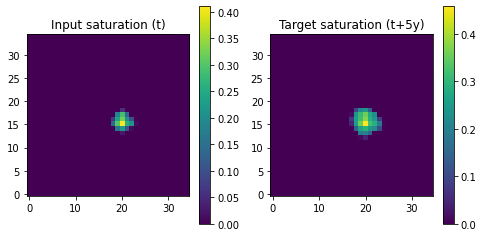

In [22]:
# pick arbitrary sample
X, Y = train_dataset[11]
s_in  = X[1].numpy()[:, :, 3]   # saturation input at mid z
s_out = Y[1].numpy()[:, :, 3]   # saturation target at mid z

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im0 = axs[0].imshow(s_in, origin='lower', cmap='viridis')
axs[0].set_title("Input saturation (t)")
im1 = axs[1].imshow(s_out, origin='lower', cmap='viridis')
axs[1].set_title("Target saturation (t+5y)")
plt.colorbar(im0)
plt.colorbar(im1)
plt.show()

## Model

In [23]:
class CO2Transformer3D(nn.Module):
    """
    Patch-based 3D Transformer surrogate for CO2 storage.

    Input:  x  of shape (B, C_in, Nx, Ny, Nz)
    Output: y  of shape (B, 2,  Nx, Ny, Nz)  -> [pressure, saturation]
    """

    def __init__(
        self,
        in_ch: int = 4,
        out_ch: int = 2,
        vol_shape: tuple = (35, 35, 11),
        patch_size: tuple = (5, 5, 1),
        d_model: int = 128,
        nhead: int = 4,
        num_layers: int = 4,
        dim_feedforward: int = 256,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.vol_shape = vol_shape
        self.patch_size = patch_size

        Nx, Ny, Nz = vol_shape
        px, py, pz = patch_size

        # Make sure the volume can be evenly split into patches
        assert Nx % px == 0 and Ny % py == 0 and Nz % pz == 0, \
            f"Volume {vol_shape} must be divisible by patch_size {patch_size}"

        # Grid size after patchification
        self.gx = Nx // px   # 35 / 5 = 7
        self.gy = Ny // py   # 35 / 5 = 7
        self.gz = Nz // pz   # 11 / 1 = 11
        self.num_tokens = self.gx * self.gy * self.gz    # 7 * 7 * 11 = 539
        self.patch_volume = px * py * pz                 # 5 * 5 * 1 = 25

        # 1) Patch embedding: Conv3d with stride = patch size
        self.patch_embed = nn.Conv3d(
            in_ch,
            d_model,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0,
            bias=True,
        )

        # 2) Learnable positional embeddings for each patch token
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.num_tokens, d_model)
        )

        # 3) Standard Transformer encoder (operates on patch tokens)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,   # (B, L, D)
            activation="gelu",
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

        # 4) Head: map token embeddings back to per-voxel predictions in each patch
        self.head = nn.Linear(d_model, out_ch * self.patch_volume)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.patch_embed.weight)
        if self.patch_embed.bias is not None:
            nn.init.zeros_(self.patch_embed.bias)
        nn.init.normal_(self.pos_embed, std=0.02)
        nn.init.xavier_uniform_(self.head.weight)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, C_in, Nx, Ny, Nz)
        returns: (B, 2, Nx, Ny, Nz)
        """
        B, C, Nx, Ny, Nz = x.shape
        px, py, pz = self.patch_size

        # 1) Patchify & embed -> (B, d_model, gx, gy, gz)
        x = self.patch_embed(x)

        # Check grid sizes
        _, D, gx, gy, gz = x.shape
        assert gx == self.gx and gy == self.gy and gz == self.gz, \
            "Unexpected grid size after patch embedding"

        # 2) Flatten spatial dims -> (B, L, d_model)
        x = x.flatten(2).transpose(1, 2)  # (B, L, D)
        L = x.size(1)
        if L != self.num_tokens:
            raise RuntimeError(f"Token length mismatch: {L} vs {self.num_tokens}")

        # 3) Add positional encoding
        x = x + self.pos_embed  # broadcast over batch

        # 4) Transformer encoder
        x = self.encoder(x)  # (B, L, D)

        # 5) Predict per-voxel values inside each patch
        x = self.head(x)  # (B, L, out_ch * patch_volume)

        # 6) Reshape back to 3D volume through "unpatchify"
        x = x.view(
            B,
            self.gx,
            self.gy,
            self.gz,
            self.out_ch,
            px,
            py,
            pz,
        )  # (B, gx, gy, gz, C, px, py, pz)

        # Rearrange to (B, C, Nx, Ny, Nz)
        x = x.permute(0, 4, 1, 5, 2, 6, 3, 7)  # (B, C, gx, px, gy, py, gz, pz)
        x = x.reshape(B, self.out_ch, Nx, Ny, Nz)

        # 7) Match the old model's convention:
        #    channel 0: pressure (linear)
        #    channel 1: saturation (sigmoid in [0,1])
        p = x[:, 0:1, ...]
        s = x[:, 1:2, ...]
        s = torch.sigmoid(s)

        out = torch.cat([p, s], dim=1)  # (B, 2, Nx, Ny, Nz)
        return out

In [24]:
C_in = 4   # number of input channels
C_out = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the Transformer-based surrogate
torch.manual_seed(SEED)
model = CO2Transformer3D(
    in_ch=C_in,
    out_ch=C_out,
    vol_shape=(35, 35, 11),
    patch_size=(5, 5, 1),   # 7x7x11 tokens
    d_model= 256, # baseline is 128, we're trying various sizes
    nhead= 8,     # We experimented with various attention heads
    num_layers= 8,           # We experimented with various num of layers
    dim_feedforward= 512,
    dropout=0.1,
).to(device)

In [25]:
summary(model,input_size=(1,4, 35, 35, 11), device='cuda')

Layer (type:depth-idx)                        Output Shape              Param #
CO2Transformer3D                              [1, 2, 35, 35, 11]        137,984
├─Conv3d: 1-1                                 [1, 256, 7, 7, 11]        25,856
├─TransformerEncoder: 1-2                     [1, 539, 256]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 539, 256]             527,104
│    │    └─TransformerEncoderLayer: 3-2      [1, 539, 256]             527,104
│    │    └─TransformerEncoderLayer: 3-3      [1, 539, 256]             527,104
│    │    └─TransformerEncoderLayer: 3-4      [1, 539, 256]             527,104
│    │    └─TransformerEncoderLayer: 3-5      [1, 539, 256]             527,104
│    │    └─TransformerEncoderLayer: 3-6      [1, 539, 256]             527,104
│    │    └─TransformerEncoderLayer: 3-7      [1, 539, 256]             527,104
│    │    └─TransformerEncoderLayer: 3-8      [1, 5

In [26]:
# ---------------------------
# Loss function
# ---------------------------
def loss_fn(pred, target, lambda_s=1.0, plume_tau=0.02, plume_w=10):
    """
    pred, target: tensors of shape (B, 2, 35, 35, 11)
    lambda_s: weighting factor for saturation term
    """
    # Split into pressure and saturation channels
    P_pred, S_pred = pred[:, 0], pred[:, 1]
    P_true, S_true = target[:, 0], target[:, 1]
    
    # L1 loss for each field
    loss_p = F.mse_loss(P_pred, P_true)
    #loss_s = F.mse_loss(S_pred, S_true)
    w = torch.ones_like(S_true)
    w = torch.where(S_true > plume_tau, torch.full_like(w, plume_w), w)
    loss_s = (w * (S_pred - S_true)**2).mean()
    
    
    total_loss = loss_p + lambda_s * loss_s 
    return total_loss, loss_p.item(), loss_s.item()


In [27]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [28]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5, patience=5,
                                                 verbose=True)

In [29]:
# Track metrics across epochs
train_total_hist, val_total_hist = [], []
train_p_hist, train_s_hist = [], []
val_p_hist, val_s_hist = [], []

# ---------------------------
# Configuration
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 100
lambda_s = 1.0      # weight for saturation term
log_interval = 4000   # print every N batches

# Move model to GPU/CPU
model = model.to(device)

# ---------------------------
# Training and validation loops
# ---------------------------
def train_one_epoch(model, dataloader, optimizer, lambda_s=1.0):
    model.train()
    running_loss, running_p, running_s = 0.0, 0.0, 0.0

    for batch_idx, (X, Y) in enumerate(tqdm(dataloader, desc="Training", leave=False)):
        X, Y = X.to(device), Y.to(device)

        # Forward
        pred = model(X)
        loss, loss_p, loss_s = loss_fn(pred, Y, lambda_s=lambda_s)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # gradient clipping
        optimizer.step()

        running_loss += loss.item()
        running_p += loss_p
        running_s += loss_s

        if (batch_idx + 1) % log_interval == 0:
            print(f"  [Batch {batch_idx+1}/{len(dataloader)}] "
                  f"Loss: {loss.item():.4f} | L_P: {loss_p:.4f} | L_S: {loss_s:.4f}")

    n = len(dataloader)
    return running_loss / n, running_p / n, running_s / n


@torch.no_grad()
def evaluate(model, dataloader, lambda_s=1.0):
    model.eval()
    total_loss, total_p, total_s = 0.0, 0.0, 0.0

    for X, Y in tqdm(dataloader, desc="Validation", leave=False):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        loss, loss_p, loss_s = loss_fn(pred, Y, lambda_s=lambda_s)
        total_loss += loss.item()
        total_p += loss_p
        total_s += loss_s

    n = len(dataloader)
    return total_loss / n, total_p / n, total_s / n


# ---------------------------
# Main training loop
# ---------------------------
best_val_loss = float('inf')

start_time = time.time()
for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    train_loss, train_p, train_s = train_one_epoch(model, train_loader, optimizer, lambda_s)
    torch.cuda.empty_cache()
    val_loss, val_p, val_s = evaluate(model, dev_loader, lambda_s)
    torch.cuda.empty_cache()

    print(f"  Train: L={train_loss:.4f} | L_P={train_p:.4f} | L_S={train_s:.4f}")
    print(f"  Valid: L={val_loss:.4f} | L_P={val_p:.4f} | L_S={val_s:.4f}")

    # Record history
    train_total_hist.append(train_loss)
    val_total_hist.append(val_loss)
    train_p_hist.append(train_p)
    train_s_hist.append(train_s)
    val_p_hist.append(val_p)
    val_s_hist.append(val_s)

    if 'scheduler' in locals():
        scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_CO2Tranformer.pt")
        print("Saved new best model")

end_time = time.time()
training_time = end_time - start_time
print("Training time: %.4f" %(training_time))
print("\nTraining complete. Best validation loss:", best_val_loss)



Epoch 1/100


  Train: L=0.1246 | L_P=0.1031 | L_S=0.0214
  Valid: L=0.0460 | L_P=0.0360 | L_S=0.0099
Saved new best model

Epoch 2/100


  Train: L=0.0501 | L_P=0.0427 | L_S=0.0073
  Valid: L=0.0329 | L_P=0.0281 | L_S=0.0048
Saved new best model

Epoch 3/100


  Train: L=0.0351 | L_P=0.0307 | L_S=0.0045
  Valid: L=0.0238 | L_P=0.0204 | L_S=0.0035
Saved new best model

Epoch 4/100


  Train: L=0.0288 | L_P=0.0253 | L_S=0.0035
  Valid: L=0.0242 | L_P=0.0214 | L_S=0.0029

Epoch 5/100


  Train: L=0.0238 | L_P=0.0208 | L_S=0.0030
  Valid: L=0.0159 | L_P=0.0135 | L_S=0.0024
Saved new best model

Epoch 6/100


  Train: L=0.0188 | L_P=0.0162 | L_S=0.0026
  Valid: L=0.0135 | L_P=0.0113 | L_S=0.0022
Saved new best model

Epoch 7/100


  Train: L=0.0142 | L_P=0.0118 | L_S=0.0023
  Valid: L=0.0094 | L_P=0.0074 | L_S=0.0019
Saved new best model

Epoch 8/100


  Train: L=0.0102 | L_P=0.0081 | L_S=0.0021
  Valid: L=0.0061 | L_P=0.0044 | L_S=0.0017
Saved new best model

Epoch 9/100


  Train: L=0.0079 | L_P=0.0060 | L_S=0.0019
  Valid: L=0.0064 | L_P=0.0048 | L_S=0.0016

Epoch 10/100


  Train: L=0.0065 | L_P=0.0048 | L_S=0.0017
  Valid: L=0.0046 | L_P=0.0032 | L_S=0.0014
Saved new best model

Epoch 11/100


  Train: L=0.0058 | L_P=0.0043 | L_S=0.0015
  Valid: L=0.0036 | L_P=0.0024 | L_S=0.0012
Saved new best model

Epoch 12/100


  Train: L=0.0049 | L_P=0.0035 | L_S=0.0014
  Valid: L=0.0033 | L_P=0.0022 | L_S=0.0011
Saved new best model

Epoch 13/100


  Train: L=0.0045 | L_P=0.0032 | L_S=0.0013
  Valid: L=0.0043 | L_P=0.0032 | L_S=0.0011

Epoch 14/100


  Train: L=0.0041 | L_P=0.0029 | L_S=0.0012
  Valid: L=0.0036 | L_P=0.0026 | L_S=0.0010

Epoch 15/100


  Train: L=0.0036 | L_P=0.0025 | L_S=0.0011
  Valid: L=0.0025 | L_P=0.0016 | L_S=0.0009
Saved new best model

Epoch 16/100


  Train: L=0.0035 | L_P=0.0024 | L_S=0.0011
  Valid: L=0.0024 | L_P=0.0015 | L_S=0.0008
Saved new best model

Epoch 17/100


  Train: L=0.0032 | L_P=0.0022 | L_S=0.0010
  Valid: L=0.0021 | L_P=0.0013 | L_S=0.0008
Saved new best model

Epoch 18/100


  Train: L=0.0030 | L_P=0.0021 | L_S=0.0009
  Valid: L=0.0024 | L_P=0.0016 | L_S=0.0008

Epoch 19/100


  Train: L=0.0028 | L_P=0.0019 | L_S=0.0009
  Valid: L=0.0023 | L_P=0.0015 | L_S=0.0007

Epoch 20/100


  Train: L=0.0027 | L_P=0.0019 | L_S=0.0008
  Valid: L=0.0022 | L_P=0.0015 | L_S=0.0007

Epoch 21/100


  Train: L=0.0024 | L_P=0.0016 | L_S=0.0008
  Valid: L=0.0019 | L_P=0.0012 | L_S=0.0007
Saved new best model

Epoch 22/100


  Train: L=0.0022 | L_P=0.0015 | L_S=0.0008
  Valid: L=0.0016 | L_P=0.0010 | L_S=0.0006
Saved new best model

Epoch 23/100


  Train: L=0.0024 | L_P=0.0017 | L_S=0.0007
  Valid: L=0.0016 | L_P=0.0010 | L_S=0.0006
Saved new best model

Epoch 24/100


  Train: L=0.0020 | L_P=0.0013 | L_S=0.0007
  Valid: L=0.0016 | L_P=0.0010 | L_S=0.0006

Epoch 25/100


  Train: L=0.0020 | L_P=0.0013 | L_S=0.0007
  Valid: L=0.0014 | L_P=0.0009 | L_S=0.0006
Saved new best model

Epoch 26/100


  Train: L=0.0019 | L_P=0.0013 | L_S=0.0007
  Valid: L=0.0013 | L_P=0.0008 | L_S=0.0005
Saved new best model

Epoch 27/100


  Train: L=0.0019 | L_P=0.0013 | L_S=0.0006
  Valid: L=0.0014 | L_P=0.0009 | L_S=0.0005

Epoch 28/100


  Train: L=0.0018 | L_P=0.0012 | L_S=0.0006
  Valid: L=0.0017 | L_P=0.0011 | L_S=0.0005

Epoch 29/100


  Train: L=0.0018 | L_P=0.0012 | L_S=0.0006
  Valid: L=0.0013 | L_P=0.0008 | L_S=0.0005
Saved new best model

Epoch 30/100


  Train: L=0.0016 | L_P=0.0010 | L_S=0.0006
  Valid: L=0.0014 | L_P=0.0009 | L_S=0.0005

Epoch 31/100


  Train: L=0.0017 | L_P=0.0012 | L_S=0.0006
  Valid: L=0.0012 | L_P=0.0008 | L_S=0.0005
Saved new best model

Epoch 32/100


  Train: L=0.0014 | L_P=0.0009 | L_S=0.0005
  Valid: L=0.0011 | L_P=0.0007 | L_S=0.0005
Saved new best model

Epoch 33/100


  Train: L=0.0015 | L_P=0.0010 | L_S=0.0005
  Valid: L=0.0011 | L_P=0.0006 | L_S=0.0004
Saved new best model

Epoch 34/100


  Train: L=0.0014 | L_P=0.0009 | L_S=0.0005
  Valid: L=0.0012 | L_P=0.0007 | L_S=0.0004

Epoch 35/100


  Train: L=0.0014 | L_P=0.0009 | L_S=0.0005
  Valid: L=0.0015 | L_P=0.0010 | L_S=0.0004

Epoch 36/100


  Train: L=0.0014 | L_P=0.0009 | L_S=0.0005
  Valid: L=0.0013 | L_P=0.0009 | L_S=0.0004

Epoch 37/100


  Train: L=0.0014 | L_P=0.0009 | L_S=0.0005
  Valid: L=0.0014 | L_P=0.0010 | L_S=0.0004

Epoch 38/100


  Train: L=0.0013 | L_P=0.0008 | L_S=0.0005
  Valid: L=0.0012 | L_P=0.0008 | L_S=0.0004

Epoch 39/100


  Train: L=0.0012 | L_P=0.0007 | L_S=0.0005
  Valid: L=0.0010 | L_P=0.0007 | L_S=0.0004
Saved new best model

Epoch 40/100


  Train: L=0.0012 | L_P=0.0008 | L_S=0.0005
  Valid: L=0.0009 | L_P=0.0005 | L_S=0.0004
Saved new best model

Epoch 41/100


  Train: L=0.0012 | L_P=0.0007 | L_S=0.0004
  Valid: L=0.0010 | L_P=0.0006 | L_S=0.0004

Epoch 42/100


  Train: L=0.0011 | L_P=0.0007 | L_S=0.0004
  Valid: L=0.0010 | L_P=0.0007 | L_S=0.0004

Epoch 43/100


  Train: L=0.0011 | L_P=0.0007 | L_S=0.0004
  Valid: L=0.0011 | L_P=0.0007 | L_S=0.0004

Epoch 44/100


  Train: L=0.0014 | L_P=0.0009 | L_S=0.0005
  Valid: L=0.0008 | L_P=0.0004 | L_S=0.0003
Saved new best model

Epoch 45/100


  Train: L=0.0009 | L_P=0.0005 | L_S=0.0004
  Valid: L=0.0008 | L_P=0.0005 | L_S=0.0003

Epoch 46/100


  Train: L=0.0010 | L_P=0.0006 | L_S=0.0004
  Valid: L=0.0008 | L_P=0.0004 | L_S=0.0003

Epoch 47/100


  Train: L=0.0018 | L_P=0.0013 | L_S=0.0005
  Valid: L=0.0010 | L_P=0.0007 | L_S=0.0004

Epoch 48/100


  Train: L=0.0009 | L_P=0.0005 | L_S=0.0004
  Valid: L=0.0008 | L_P=0.0004 | L_S=0.0003
Saved new best model

Epoch 49/100


  Train: L=0.0009 | L_P=0.0005 | L_S=0.0004
  Valid: L=0.0008 | L_P=0.0004 | L_S=0.0003
Saved new best model

Epoch 50/100


  Train: L=0.0009 | L_P=0.0005 | L_S=0.0004
  Valid: L=0.0009 | L_P=0.0006 | L_S=0.0003

Epoch 51/100


  Train: L=0.0010 | L_P=0.0006 | L_S=0.0004
  Valid: L=0.0013 | L_P=0.0010 | L_S=0.0003

Epoch 52/100


  Train: L=0.0011 | L_P=0.0007 | L_S=0.0004
  Valid: L=0.0008 | L_P=0.0005 | L_S=0.0003

Epoch 53/100


  Train: L=0.0009 | L_P=0.0005 | L_S=0.0004
  Valid: L=0.0009 | L_P=0.0006 | L_S=0.0003

Epoch 54/100


  Train: L=0.0009 | L_P=0.0006 | L_S=0.0004
  Valid: L=0.0008 | L_P=0.0005 | L_S=0.0003

Epoch 55/100


  Train: L=0.0010 | L_P=0.0006 | L_S=0.0004
  Valid: L=0.0008 | L_P=0.0005 | L_S=0.0003
Epoch 00055: reducing learning rate of group 0 to 5.0000e-05.

Epoch 56/100


  Train: L=0.0007 | L_P=0.0004 | L_S=0.0003
  Valid: L=0.0006 | L_P=0.0003 | L_S=0.0003
Saved new best model

Epoch 57/100


  Train: L=0.0007 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0006 | L_P=0.0003 | L_S=0.0003
Saved new best model

Epoch 58/100


  Train: L=0.0007 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0006 | L_P=0.0003 | L_S=0.0003

Epoch 59/100


  Train: L=0.0007 | L_P=0.0004 | L_S=0.0003
  Valid: L=0.0006 | L_P=0.0003 | L_S=0.0003

Epoch 60/100


  Train: L=0.0007 | L_P=0.0004 | L_S=0.0003
  Valid: L=0.0006 | L_P=0.0003 | L_S=0.0003

Epoch 61/100


  Train: L=0.0007 | L_P=0.0004 | L_S=0.0003
  Valid: L=0.0006 | L_P=0.0003 | L_S=0.0003
Saved new best model

Epoch 62/100


  Train: L=0.0007 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0006 | L_P=0.0003 | L_S=0.0003

Epoch 63/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0006 | L_P=0.0003 | L_S=0.0003

Epoch 64/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0006 | L_P=0.0003 | L_S=0.0003

Epoch 65/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0003
Saved new best model

Epoch 66/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0003

Epoch 67/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0006 | L_P=0.0003 | L_S=0.0003

Epoch 68/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0006 | L_P=0.0004 | L_S=0.0002

Epoch 69/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002
Saved new best model

Epoch 70/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 71/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 72/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002
Saved new best model

Epoch 73/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 74/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 75/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 76/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002
Saved new best model

Epoch 77/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 78/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 79/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 80/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 81/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0002 | L_S=0.0002
Saved new best model

Epoch 82/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 83/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 84/100


  Train: L=0.0005 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0002 | L_S=0.0002
Saved new best model

Epoch 85/100


  Train: L=0.0005 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 86/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 87/100


  Train: L=0.0005 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0002 | L_S=0.0002
Saved new best model

Epoch 88/100


  Train: L=0.0005 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0002 | L_S=0.0002

Epoch 89/100


  Train: L=0.0005 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0002 | L_S=0.0002

Epoch 90/100


  Train: L=0.0005 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0005 | L_P=0.0002 | L_S=0.0002

Epoch 91/100


  Train: L=0.0006 | L_P=0.0003 | L_S=0.0003
  Valid: L=0.0004 | L_P=0.0002 | L_S=0.0002
Saved new best model

Epoch 92/100


  Train: L=0.0005 | L_P=0.0003 | L_S=0.0002
  Valid: L=0.0004 | L_P=0.0002 | L_S=0.0002

Epoch 93/100


  Train: L=0.0005 | L_P=0.0002 | L_S=0.0002
  Valid: L=0.0004 | L_P=0.0002 | L_S=0.0002
Saved new best model

Epoch 94/100


  Train: L=0.0005 | L_P=0.0003 | L_S=0.0002
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 95/100


  Train: L=0.0005 | L_P=0.0003 | L_S=0.0002
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 96/100


  Train: L=0.0005 | L_P=0.0003 | L_S=0.0002
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002

Epoch 97/100


  Train: L=0.0005 | L_P=0.0003 | L_S=0.0002
  Valid: L=0.0005 | L_P=0.0003 | L_S=0.0002
Epoch 00099: reducing learning rate of group 0 to 2.5000e-05.

Epoch 100/100


  Train: L=0.0004 | L_P=0.0002 | L_S=0.0002
  Valid: L=0.0004 | L_P=0.0002 | L_S=0.0002
Saved new best model
Training time: 5377.2945

Training complete. Best validation loss: 0.0003982629452366382


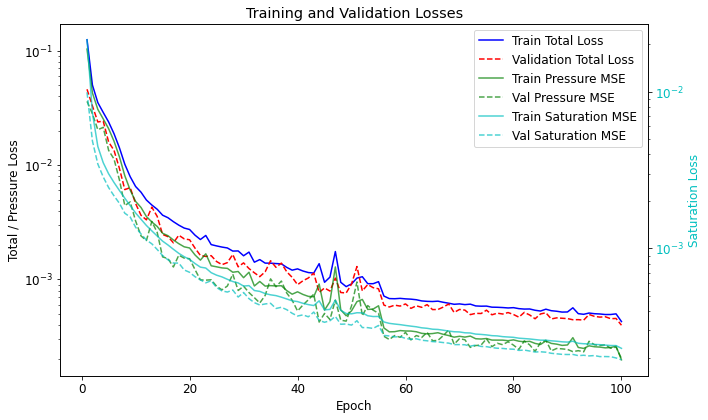

In [92]:
epochs = range(1, len(train_total_hist) + 1)
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Primary y-axis: total + pressure losses ---
ax1.plot(epochs, train_total_hist, 'b-', label='Train Total Loss')
ax1.plot(epochs, val_total_hist, 'r--', label='Validation Total Loss')
ax1.plot(epochs, train_p_hist, 'g-', alpha=0.7, label='Train Pressure MSE')
ax1.plot(epochs, val_p_hist, 'g--', alpha=0.7, label='Val Pressure MSE')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Total / Pressure Loss")
ax1.tick_params(axis='y', labelcolor='k')
#plt.ylim([0,1])
plt.yscale('log')

# --- Secondary y-axis: saturation losses ---
ax2 = ax1.twinx()
ax2.plot(epochs, train_s_hist, 'c-', alpha=0.7, label='Train Saturation MSE')
ax2.plot(epochs, val_s_hist, 'c--', alpha=0.7, label='Val Saturation MSE')
ax2.set_ylabel("Saturation Loss", color='c')
ax2.tick_params(axis='y', labelcolor='c')


# --- Combined legend ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.yscale('log')

plt.title("Training and Validation Losses")
plt.tight_layout()
plt.show()

In [36]:
print("model param id:", id(list(model.parameters())[0]))
print("opt   param id:", id(optimizer.param_groups[0]['params'][0]))

model param id: 139692421926080
opt   param id: 139692421926080


In [37]:
model.train()
X_small, Y_small = next(iter(train_loader))  # one batch
X_small, Y_small = X_small.to(device), Y_small.to(device)

opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.0)  # higher lr, no wd

for i in range(50):
    opt.zero_grad()
    pred = model(X_small)
    loss, lp, ls = loss_fn(pred, Y_small, lambda_s=1.0)
    loss.backward()
    opt.step()
    if (i+1) % 5 == 0:
        print(f"iter {i+1:02d}: loss={loss.item():.4f}  Lp={lp:.4f}  Ls={ls:.4f}")


iter 05: loss=0.0869  Lp=0.0764  Ls=0.0104
iter 10: loss=0.0507  Lp=0.0426  Ls=0.0081
iter 15: loss=0.0286  Lp=0.0223  Ls=0.0063
iter 20: loss=0.0204  Lp=0.0152  Ls=0.0052
iter 25: loss=0.0162  Lp=0.0119  Ls=0.0043
iter 30: loss=0.0128  Lp=0.0094  Ls=0.0034
iter 35: loss=0.0102  Lp=0.0072  Ls=0.0031
iter 40: loss=0.0081  Lp=0.0054  Ls=0.0027
iter 45: loss=0.0070  Lp=0.0046  Ls=0.0024
iter 50: loss=0.0063  Lp=0.0041  Ls=0.0022


In [38]:
optimizer.zero_grad()
pred = model(X_small)
loss, _, _ = loss_fn(pred, Y_small)
loss.backward()

total_norm = 0.0
nz_params = 0
for p in model.parameters():
    if p.grad is not None:
        g = p.grad.data
        total_norm += (g.norm(2).item())**2
        nz_params += int(g.abs().sum().item() > 0)
print(f"grad_norm={total_norm**0.5:.2e}, nz_grad_params={nz_params}")


grad_norm=6.27e-02, nz_grad_params=101


In [39]:
# One sample from dataset, BEFORE batching
X, Y = train_dataset[0]
P_in, S_in = X[0].numpy(), X[1].numpy()
P_tgt, S_tgt = Y[0].numpy(), Y[1].numpy()
print("P_in mean/std:", P_in.mean(), P_in.std())
print("P_tgt mean/std:", P_tgt.mean(), P_tgt.std())
print("S_in range:", S_in.min(), S_in.max())
print("S_tgt range:", S_tgt.min(), S_tgt.max())


P_in mean/std: 0.19534595 0.96222216
P_tgt mean/std: 0.31858677 1.0651975
S_in range: 0.0 0.0
S_tgt range: 0.0 0.44979122


In [40]:
# on a random batch
Xb, Yb = next(iter(train_loader))
S_true = Yb[:,1]  # (B,35,35,11)

print("S_true stats:",
      "mean=", S_true.mean().item(),
      "max=",  S_true.max().item())

frac_plume = (S_true > 0.02).float().mean().item()
print("Fraction of cells with S > 0.02:", frac_plume)


S_true stats: mean= 0.009282740764319897 max= 0.6460824608802795
Fraction of cells with S > 0.02: 0.04579591751098633


## Loss Visualization

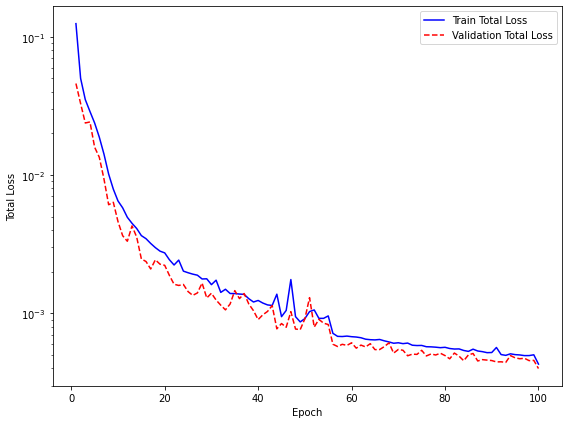

In [41]:
epochs = range(1, len(train_total_hist) + 1)
fig, ax1 = plt.subplots(figsize=(8, 6))

# --- Primary y-axis: total + pressure losses ---
ax1.plot(epochs, train_total_hist, 'b-', label='Train Total Loss')
ax1.plot(epochs, val_total_hist, 'r--', label='Validation Total Loss')
# ax1.plot(epochs, train_p_hist, 'g-', alpha=0.7, label='Train Pressure MSE')
# ax1.plot(epochs, val_p_hist, 'g--', alpha=0.7, label='Val Pressure MSE')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Total Loss")
ax1.tick_params(axis='y', labelcolor='k')
#plt.ylim([0,1])
plt.yscale('log')

# --- Secondary y-axis: saturation losses ---
#ax2 = ax1.twinx()
#ax2.plot(epochs, train_s_hist, 'c-', alpha=0.7, label='Train Saturation MSE')
#ax2.plot(epochs, val_s_hist, 'c--', alpha=0.7, label='Val Saturation MSE')
#ax2.set_ylabel("Saturation Loss", color='c')
#ax2.tick_params(axis='y', labelcolor='c')
#plt.yscale('log')

# --- Combined legend ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
#lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 , labels_1 , loc='upper right')


# plt.title("Training and Validation Losses")
plt.tight_layout()
plt.savefig('train_val loss.png', dpi=600)
plt.show()

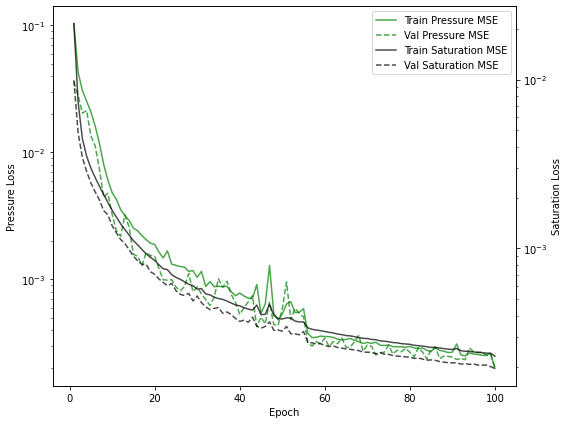

In [42]:
epochs = range(1, len(train_total_hist) + 1)
fig, ax1 = plt.subplots(figsize=(8, 6))

# --- Primary y-axis: total + pressure losses ---
#ax1.plot(epochs, train_total_hist, 'b-', label='Train Total Loss')
#ax1.plot(epochs, val_total_hist, 'r--', label='Validation Total Loss')
ax1.plot(epochs, train_p_hist, 'g-', alpha=0.7, label='Train Pressure MSE')
ax1.plot(epochs, val_p_hist, 'g--', alpha=0.7, label='Val Pressure MSE')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Pressure Loss")
ax1.tick_params(axis='y', labelcolor='k')
#plt.ylim([0,1])
plt.yscale('log')

# --- Secondary y-axis: saturation losses ---
ax2 = ax1.twinx()
ax2.plot(epochs, train_s_hist, 'k-', alpha=0.7, label='Train Saturation MSE')
ax2.plot(epochs, val_s_hist, 'k--', alpha=0.7, label='Val Saturation MSE')
ax2.set_ylabel("Saturation Loss", color='k')
ax2.tick_params(axis='y', labelcolor='k')
plt.yscale('log')

# --- Combined legend ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')


#plt.title("Training and Validation Losses")
plt.tight_layout()
plt.savefig('press sat train_val loss.png', dpi=600)
plt.show()

## Test Set Evaluation

In [43]:
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [44]:
start_time = time.time()
model.eval()
preds_P, preds_S = [], []
truth_P, truth_S = [], []

with torch.no_grad():
    for X, Y in tqdm(test_loader, desc="Evaluating on test set"):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)

        P_pred, S_pred = pred[:, 0].cpu().numpy(), pred[:, 1].cpu().numpy()
        P_true, S_true = Y[:, 0].cpu().numpy(), Y[:, 1].cpu().numpy()

        preds_P.append(P_pred)
        preds_S.append(S_pred)
        truth_P.append(P_true)
        truth_S.append(S_true)

end_time = time.time()
test_time = end_time - start_time
print("Test time: %.4f" %(test_time))
# concatenate along batch dimension
preds_P = np.concatenate(preds_P, axis=0)
preds_S = np.concatenate(preds_S, axis=0)
truth_P = np.concatenate(truth_P, axis=0)
truth_S = np.concatenate(truth_S, axis=0)


Evaluating on test set: 100%|██████████| 100/100 [00:02<00:00, 38.61it/s]


Test time: 2.5953


## Post processing
### Feel free to ignore anything beneath this

In [53]:
# flatten everything (B, X, Y, Z) → 1D
p_pred_flat = preds_P.flatten()
p_true_flat = truth_P.flatten()
s_pred_flat = preds_S.flatten()
s_true_flat = truth_S.flatten()

metrics = {}

for name, pred, true in [
    ("Pressure", p_pred_flat, p_true_flat),
    ("Saturation", s_pred_flat, s_true_flat),
]:
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    metrics[name] = dict(RMSE=rmse, MAE=mae, R2=r2)

metrics

{'Pressure': {'RMSE': 0.24735791350759379,
  'MAE': 0.11015689373016357,
  'R2': 0.9390081763267517},
 'Saturation': {'RMSE': 0.025551602023958456,
  'MAE': 0.01928224414587021,
  'R2': 0.7361506223678589}}

In [54]:
abs_err_P = np.abs(p_pred_flat - p_true_flat)
abs_err_S = np.abs(s_pred_flat - s_true_flat)

percentiles = [10, 50, 90]
p_P = np.percentile(abs_err_P, percentiles)
p_S = np.percentile(abs_err_S, percentiles)

print(f"Pressure Abs Error P10/P50/P90: {p_P}")
print(f"Saturation Abs Error P10/P50/P90: {p_S}")

Pressure Abs Error P10/P50/P90: [0.00477076 0.02760351 0.33419246]
Saturation Abs Error P10/P50/P90: [0.00831147 0.01540229 0.03209501]


/tmp/ipykernel_235095/478076837.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


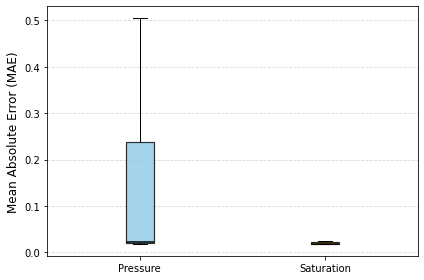

In [55]:
abs_err_P = np.abs(p_pred_flat - p_true_flat)
abs_err_S = np.abs(s_pred_flat - s_true_flat)

percentiles = [10, 50, 90]
p_P = np.percentile(abs_err_P, percentiles)
p_S = np.percentile(abs_err_S, percentiles)


# preds_P, truth_P: shape (N, 35, 35, 11)
# preds_S, truth_S: shape (N, 35, 35, 11)

N = preds_P.shape[0]

mae_P = []
mae_S = []

for i in range(N):
    p_pred = preds_P[i]
    p_true = truth_P[i]
    s_pred = preds_S[i]
    s_true = truth_S[i]

    mae_P.append(np.mean(np.abs(p_pred - p_true)))
    mae_S.append(np.mean(np.abs(s_pred - s_true)))

mae_P = np.array(mae_P)
mae_S = np.array(mae_S)

plt.figure(figsize=(6,4))

data = [mae_P, mae_S]
labels = ["Pressure", "Saturation"]
colors = ['#8ecae6', '#ffb703']

bp = plt.boxplot(
    data,
    labels=labels,
    patch_artist=True,
    medianprops=dict(color='black', linewidth=1.5),
    whiskerprops=dict(color='black'),
    boxprops=dict(linewidth=1.2, color='black')
)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set(facecolor=color, alpha=0.8)

plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

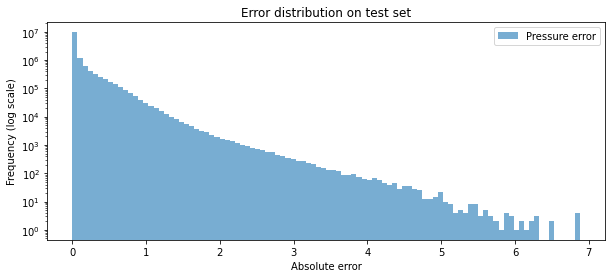

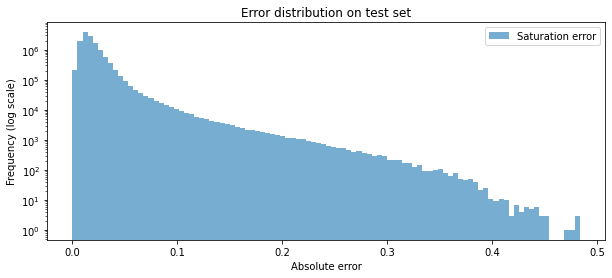

In [56]:
plt.figure(figsize=(10,4))
plt.hist(abs_err_P, bins=100, alpha=0.6, label="Pressure error")
plt.yscale('log')
plt.xlabel("Absolute error")
plt.ylabel("Frequency (log scale)")
plt.legend()
plt.title("Error distribution on test set")
plt.show()

plt.figure(figsize=(10,4))
plt.hist(abs_err_S, bins=100, alpha=0.6, label="Saturation error")
plt.yscale('log')
plt.xlabel("Absolute error")
plt.ylabel("Frequency (log scale)")
plt.legend()
plt.title("Error distribution on test set")
plt.show()

/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


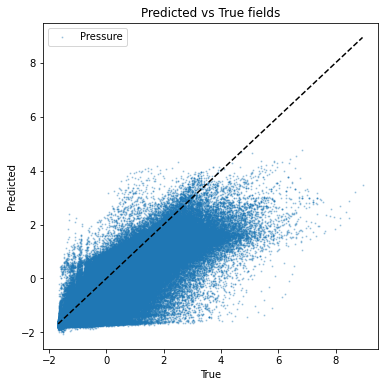

In [57]:
plt.figure(figsize=(6,6))
plt.scatter(p_true_flat, p_pred_flat, s=1, alpha=0.3, label="Pressure")
#plt.scatter(s_true_flat, s_pred_flat, s=1, alpha=0.3, label="Saturation")
plt.plot([p_true_flat.min(), p_true_flat.max()],
         [p_true_flat.min(), p_true_flat.max()],
         'k--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.title("Predicted vs True fields")
plt.show()


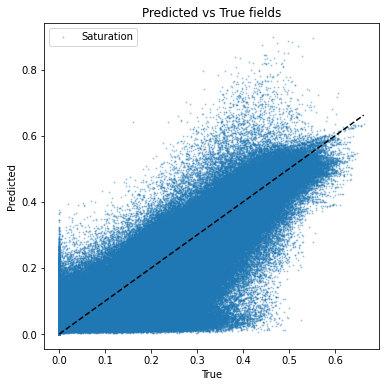

In [58]:
plt.figure(figsize=(6,6))
#plt.scatter(p_true_flat, p_pred_flat, s=1, alpha=0.3, label="Pressure")
plt.scatter(s_true_flat, s_pred_flat, s=1, alpha=0.3, label="Saturation")
plt.plot([s_true_flat.min(), s_true_flat.max()],
         [s_true_flat.min(), s_true_flat.max()],
         'k--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.title("Predicted vs True fields")
plt.show()

In [81]:
# 3D plotting helper function
def plotter3D(vars_3d, title):
    nx, ny, nz = vars_3d.shape
    #norm = matplotlib.colors.Normalize(vmin=np.min(vars_3d), vmax=np.max(vars_3d))
    norm = matplotlib.colors.Normalize(vmin=np.min(vars_3d), vmax=np.max(vars_3d))
    x, y, z = np.indices((nx + 1, ny + 1, nz + 1))
    
    plt.rc('font', size=12)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
    # ax.set_box_aspect((1, 1, 1))
    #ax.invert_zaxis()
    ax.invert_yaxis()
    # ax.invert_xaxis()
    
    ax.set_axis_off()
    
    # Add axis direction labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    
    # Hide ticks and grid lines, but keep labels
    ax.grid(False)  # Disable grid lines
    
    ax.view_init(elev=30, azim=0)  # 60, -60
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 1, 1]))
    # plotting black boundary box
    ax.plot3D([0, nx], [0, 0], [0, 0], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, nx], [0, 0], [nz, nz], 'k', linewidth=0.5)
    ax.plot3D([0, nx], [ny, ny], [0, 0], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, nx], [ny, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, 0], [0, ny], [0, 0], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([nx, nx], [0, ny], [0, 0], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([nx, nx], [0, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, 0], [0, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([nx, nx], [ny, ny], [0, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([nx, nx], [0, 0], [0, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, 0], [0, 0], [0, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, 0], [ny, ny], [0, nz], 'k', zorder=1e6, linewidth=0.5)
    
    
    colors = plt.cm.jet(norm(vars_3d.transpose((0, 1, 2))))
    filled = np.where(vars_3d.transpose((0, 1, 2)) > 0, np.ones((nx, ny, nz)), np.zeros((nx, ny, nz)))
    
    vox = ax.voxels(x, y, z, filled, facecolors=colors,
                    edgecolors=colors,  # brighter
                    linewidth=0.5,
                    alpha=1, shade=False)
    
    
    m = cm.ScalarMappable(cmap=cm.jet, norm=norm)
    m.set_array([])
    plt.colorbar(m, ax=ax, shrink=0.5, pad=0.001)
    # plt.title(title)
    plt.tight_layout()
    # plt.savefig(title+'.png', dpi=600)
    plt.show()

In [82]:
preds_P.shape, truth_P.shape, preds_S.shape, truth_S.shape

((1000, 35, 35, 11),
 (1000, 35, 35, 11),
 (1000, 35, 35, 11),
 (1000, 35, 35, 11))

In [83]:
example = 5

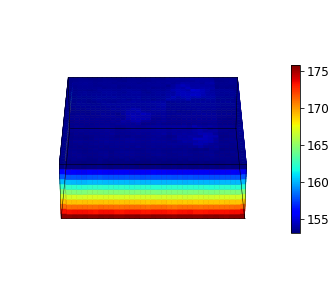

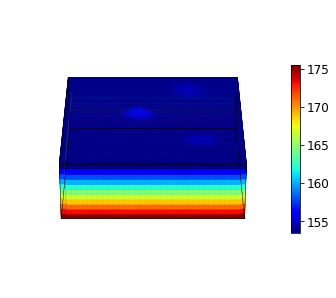

In [84]:
res_p_p = ((preds_P[example] * P_SIGMA) + P_MU) / 1e5
res_p_t = ((truth_P[example] * P_SIGMA) + P_MU) / 1e5
plotter3D(res_p_p, 'Predicted Pressure Field')
plotter3D(res_p_t, 'True Pressure Field')

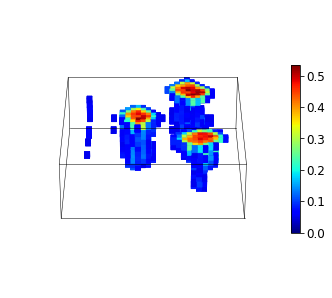

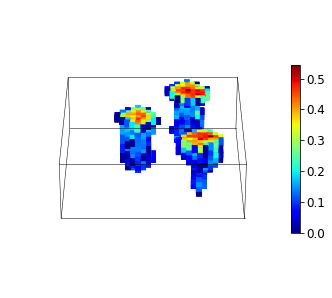

In [87]:
res_s_p = preds_S[example].copy()     # (35, 35, 11)
res_s_p[res_s_p < 0.05] = 0.0         # zero out small saturations
res_s_t = truth_S[example]
plotter3D(res_s_p, 'Predicted Saturation Field')
plotter3D(res_s_t, 'True Saturation Field')

In [88]:
def rollout_one_run(model, dataset, run_number, device):
    """
    Autoregressive rollout on a single GEOS run in test_dataset.

    run_number: integer 0 .. (num_runs-1)
    """
    model.eval()
    Nt = dataset.Nt          # 11
    steps = Nt - 1           # 10

    # compute the correct dataset index range
    base_idx = run_number * steps

    preds = []
    trues = []

    with torch.no_grad():

        # --- first step: use dataset's true initial state ---
        X_k, Y_true = dataset[base_idx]   # guaranteed to be the first transition of this run
        X_k = X_k.clone()

        X_t = X_k.unsqueeze(0).to(device)
        Y_true_t = Y_true.unsqueeze(0).to(device)

        Y_pred_t = model(X_t)

        preds.append(Y_pred_t.squeeze(0).cpu().numpy())
        trues.append(Y_true_t.squeeze(0).cpu().numpy())

        # next input state = predicted output
        P_next = Y_pred_t[0,0].cpu()
        S_next = Y_pred_t[0,1].cpu()

        # --- subsequent 9 steps ---
        for k in range(1, steps):
            idx = base_idx + k

            X_k, Y_true = dataset[idx]
            X_k = X_k.clone()

            # replace channels 0 and 1 with predicted P,S
            X_k[0] = P_next
            X_k[1] = S_next

            X_t = X_k.unsqueeze(0).to(device)
            Y_true_t = Y_true.unsqueeze(0).to(device)

            Y_pred_t = model(X_t)

            preds.append(Y_pred_t.squeeze(0).cpu().numpy())
            trues.append(Y_true_t.squeeze(0).cpu().numpy())

            P_next = Y_pred_t[0,0].cpu()
            S_next = Y_pred_t[0,1].cpu()

    preds = np.stack(preds)
    trues = np.stack(trues)
    return preds, trues


In [89]:
def plotter3D_sub(ax, vars_3d, title=""):
    nx, ny, nz = vars_3d.shape
    norm = matplotlib.colors.Normalize(vmin=np.min(vars_3d), vmax=np.max(vars_3d))

    x, y, z = np.indices((nx + 1, ny + 1, nz + 1))
    ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
    ax.invert_yaxis()
    ax.set_axis_off()

    # boundary box
    ax.plot3D([0, nx], [0, 0], [0, 0], 'k',  linewidth=0.3)
    ax.plot3D([0, nx], [0, 0], [nz, nz], 'k', linewidth=0.3)
    ax.plot3D([0, nx], [ny, ny], [0, 0], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([0, nx], [ny, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([0, 0], [0, ny], [0, 0], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([nx, nx], [0, ny], [0, 0], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([nx, nx], [0, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([0, 0], [0, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([nx, nx], [ny, ny], [0, nz], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([nx, nx], [0, 0], [0, nz], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([0, 0], [0, 0], [0, nz], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([0, 0], [ny, ny], [0, nz], 'k', zorder=1e6, linewidth=0.3)

    colors = plt.cm.jet(norm(vars_3d))
    filled = vars_3d > 0.0

    ax.voxels(
        x, y, z,
        filled,
        facecolors=colors,
        edgecolors=colors,
        linewidth=0.05,
        alpha=1.0,
        shade=False
    )

    ax.set_title(title, fontsize=10)


def compare_rollout_8panel(pred_seq, true_seq, timesteps, savefig=None):
    fig = plt.figure(figsize=(14, 7))

    for j, k in enumerate(timesteps):
        # predicted saturation
        ax = fig.add_subplot(2, 4, j+1, projection='3d')
        sat_pred = pred_seq[k, 1].copy()
        sat_pred[sat_pred < 0.05] = 0.0
        plotter3D_sub(ax, sat_pred, title=f"Pred t={5*(k+1)}y")

        # true saturation
        ax = fig.add_subplot(2, 4, j+5, projection='3d')
        sat_true = true_seq[k, 1].copy()
        sat_true[sat_true < 0.05] = 0.0
        plotter3D_sub(ax, sat_true, title=f"True t={5*(k+1)}y")

    plt.tight_layout()
    if savefig:
        plt.savefig(savefig, dpi=600)
    plt.show()

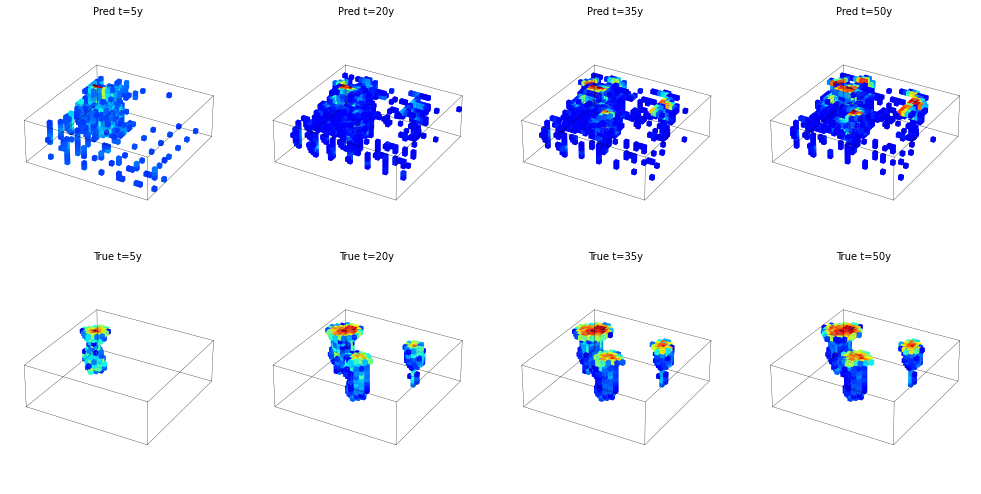

In [93]:
timesteps_to_plot = [0, 3, 6, 9]
run_number = 20     # example run
pred_seq, true_seq = rollout_one_run(model, test_dataset, run_number, device)

compare_rollout_8panel(pred_seq, true_seq, timesteps_to_plot,
                       savefig="rollout_comparison_run3.png")
